# Import

In [750]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import seaborn as sns
import datetime

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings('ignore')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [751]:
data = pd.read_csv('uy_properties.csv')

In [752]:
len(data)

43603

# Data Info

In [753]:
data.head()

,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
0,AaYeOtqgU08KoE9/jk6l3A==,Propiedad,2020-02-16,2020-03-03,2020-02-16,-34.798299,-55.907364,Uruguay,Canelones,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,500.0,38000.0,UYU,NaN,3 dormitorios El Pinar cw136659,Tiene 3 habitaciones grandes 3 baños cocina gr...,Casa,Alquiler
1,gZJGr6lvsDi2OIQdfgskuA==,Propiedad,2020-02-16,2020-03-13,2020-02-16,-34.876799,-56.177896,Uruguay,Montevideo,Jacinto Vera,NaN,NaN,NaN,NaN,1.0,1.0,NaN,50.0,18000.0,UYU,NaN,Apartamento de un dormitorio cw136657,Apartamento de un dormitorio.<br>Cocina defini...,Departamento,Alquiler
2,U54l/kpXX6fDZdP/50i1mg==,Propiedad,2020-02-16,9999-12-31,2020-02-16,-34.910376,-56.133742,Uruguay,Montevideo,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,10.0,1400.0,USD,NaN,"Alquiler, puerto del buceo ,1 dorm equipadisim...",Apartamento de 1 dormitorio completamente equi...,Departamento,Alquiler
3,QJANPfhvtS+/HNRZ5wjBBw==,Propiedad,2020-02-16,9999-12-31,2020-02-16,-34.852340,-56.195110,Uruguay,Montevideo,Aires Puros,NaN,NaN,NaN,NaN,2.0,1.0,NaN,56.0,31000.0,UYU,NaN,Apartamento de dos dormitorios cw136662,Precioso apartamento tipo casa.<br>Dos dormito...,Departamento,Alquiler
4,kbgsL6DG0Fa5Sxa8Wv7Q1w==,Propiedad,2020-02-16,9999-12-31,2020-02-16,-34.847868,-56.240044,Uruguay,Montevideo,Nuevo Paris,NaN,NaN,NaN,NaN,2.0,1.0,NaN,80.0,11500.0,UYU,NaN,"CON PATIO Y OMNIBUS EN LA PUERTA, cw130389","SE TRATA DE UN APTO AL FONDO DE UNA CASA, TIEN...",Departamento,Alquiler temporal


In [754]:
data.describe()

,lat,lon,l5,l6,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,42073.000000,42073.000000,0.0,0.0,25539.000000,37374.000000,37732.000000,1074.000000,21237.000000,4.343600e+04
mean,-34.871956,-55.703193,NaN,NaN,3.111359,2.377214,1.933796,617.163873,680.363234,2.390154e+05
std,1.078096,1.200044,NaN,NaN,1.411765,1.301313,1.157894,6877.370860,10828.107383,4.595477e+05
min,-34.972177,-180.000000,NaN,NaN,1.000000,0.000000,1.000000,10.000000,1.000000,0.000000e+00
25%,-34.920052,-56.162453,NaN,NaN,2.000000,2.000000,1.000000,45.000000,46.000000,2.300000e+04
50%,-34.905603,-56.107135,NaN,NaN,3.000000,2.000000,2.000000,63.000000,78.000000,1.380000e+05
75%,-34.884417,-54.946358,NaN,NaN,4.000000,3.000000,2.000000,127.750000,196.000000,2.800000e+05
max,85.051129,75.393681,NaN,NaN,31.000000,30.000000,20.000000,198459.000000,940000.000000,1.200000e+07


In [755]:
data.isna().sum().sort_values(ascending=False)

l6                 43603
l5                 43603
surface_total      42529
price_period       42495
l4                 41612
surface_covered    22366
rooms              18064
l3                  8658
bedrooms            6229
bathrooms           5871
lon                 1530
lat                 1530
currency             173
price                167
end_date               0
start_date             0
ad_type                0
created_on             0
operation_type         0
l1                     0
l2                     0
property_type          0
title                  0
description            0
id                     0
dtype: int64

# Missing Values

#### Many missing values and useless feats

In [756]:
many_missing = ['l1', 'l6', 'l5', 'surface_total', 'price_period', 'l4', 'rooms', 'surface_covered', 'id', 'created_on', 'title', 
                'description', 'ad_type']
for i in many_missing:
    del data[i]

#### Lat and Lon

In [757]:
coord = ['lat', 'lon']
for i in coord:
    data[i] = data[i].fillna(data[i].mean())

#### L3

In [758]:
data['l3'] = data['l3'].apply(lambda x: 'None' if pd.isna(x) else x)

#### Price

In [759]:
corr = data.corr()
indexes = corr['price'].sort_values(ascending=False).index[0:3]
indexes

Index(['price', 'bathrooms', 'bedrooms'], dtype='object')

In [760]:
data_price = data[indexes]

In [761]:
imp = IterativeImputer(max_iter=500, random_state=0)
imp.fit(data_price.values)
IterativeImputer(random_state=0)

IterativeImputer(add_indicator=False, estimator=None,
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=0,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [762]:
data['price'] = np.round(imp.transform(np.round(data_price.values))[:, 0])

#### Drop remaining

In [763]:
data = data.dropna()

# Dates

In [764]:
#Unreal Dates
data['end_date'] = data['end_date'].apply(lambda x: '2021-1-1' if (x=='9999-12-31') else x)
delta = abs(pd.to_datetime(data['start_date']) - pd.to_datetime(data['end_date']))

data['days_spam'] = delta

import re
data['days_spam'] = data['days_spam'].apply(lambda x: re.sub('\D', '', str(x))).apply(lambda x: x[:-6]).apply(lambda x: int(x))

del data['start_date']
del data['end_date']

# Badrooms and Bathrooms

In [765]:
data = data[data['bathrooms']<10]
data = data[data['bedrooms']<10]

data['bedrooms'] = data['bedrooms'].apply(lambda x: 5 if x>5 else x)
data['bathrooms'] = data['bathrooms'].apply(lambda x: 5 if x>5 else x)

# Int to Str

In [766]:
for i in ['bathrooms', 'bedrooms']:
    data[i] = data[i].apply(str)

# Outliers

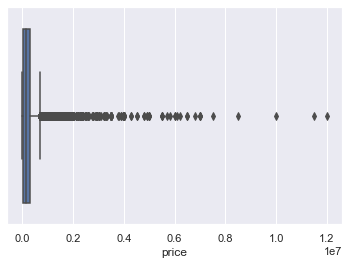

In [767]:
sns.boxplot(data['price']);

In [768]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.70)
IQR = Q3 - Q1

data_out = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]

print(len(data_out))

29203


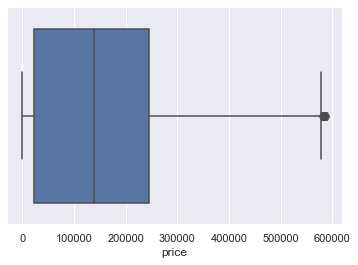

In [769]:
sns.boxplot(data_out['price']);

In [770]:
data = data_out

# Months

In [771]:
bins = list(range(0, 400, 60))
data['months'] = pd.cut(data['days_spam'], bins)

del data['days_spam']

# Target

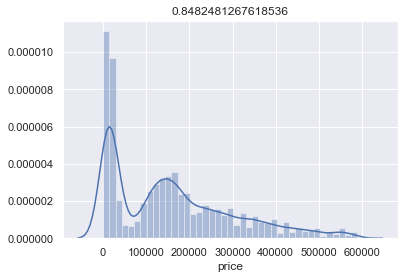

In [772]:
sns.distplot(data['price'])
plt.title(str(skew(data['price'])));

#### Ok to me

# L2

In [773]:
data['l2'].value_counts()

Montevideo    17747
Maldonado     10816
Canelones       637
Colonia           1
Rocha             1
San José          1
Name: l2, dtype: int64

In [774]:
states = ['Maldonado', 'Montevideo']
l2_data = data['l2'].apply(lambda x: x if x in(states) else 'Canelones')
data['l2'] = l2_data

# L3

In [775]:
data = data[data['l3']!='None']

# Data After Cleaning

In [776]:
data.head()

,lat,lon,l2,l3,bedrooms,bathrooms,price,currency,property_type,operation_type,months
1,-34.876799,-56.177896,Montevideo,Jacinto Vera,1.0,1.0,18000.0,UYU,Departamento,Alquiler,"(0, 60]"
3,-34.852340,-56.195110,Montevideo,Aires Puros,2.0,1.0,31000.0,UYU,Departamento,Alquiler,"(300, 360]"
4,-34.847868,-56.240044,Montevideo,Nuevo Paris,2.0,1.0,11500.0,UYU,Departamento,Alquiler temporal,"(300, 360]"
5,-34.903143,-56.159899,Montevideo,Parque Batlle,2.0,2.0,194000.0,USD,Departamento,Venta,"(300, 360]"
7,-34.917752,-56.164649,Montevideo,Punta Carretas,3.0,2.0,230000.0,USD,Departamento,Venta,"(300, 360]"


# EDA

#### Map

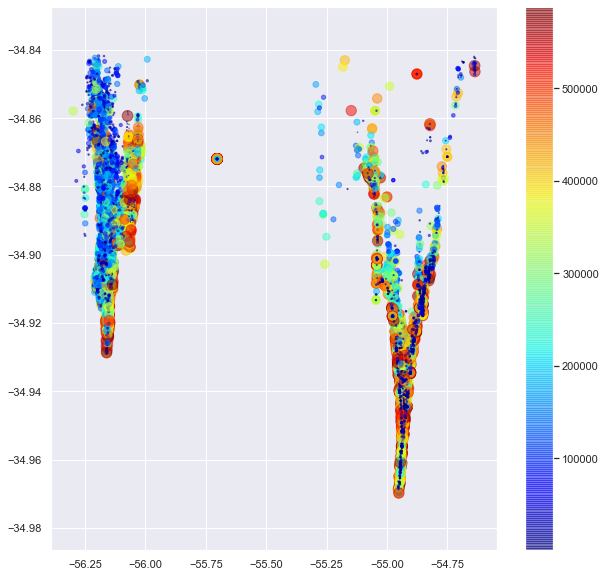

In [777]:
plt.figure(figsize=(10,10))
plt.scatter(data['lon'], data['lat'], alpha=0.5, s=data['price']/5000, c=data['price'], cmap='jet')
plt.colorbar();

#### L2 and Price

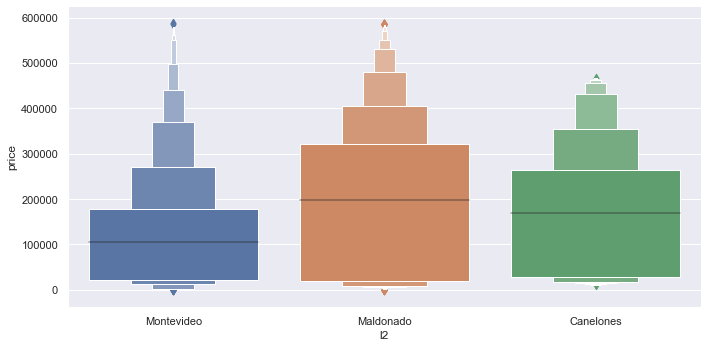

In [778]:
sns.catplot(data=data, x='l2', y='price', height=5, aspect=2, kind='boxen');

#### L3 and Price

In [779]:
cities = data['l3'].value_counts().index[29:]
data['l3'] = data['l3'].apply(lambda x: 'Other' if x in cities else x)

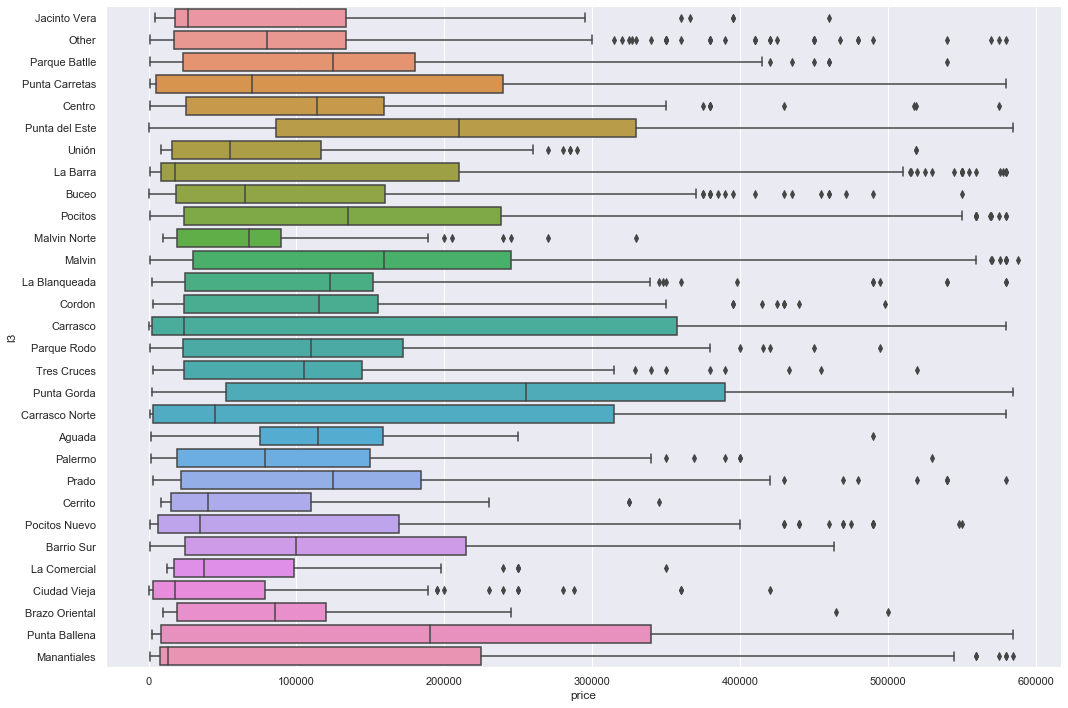

In [780]:
sns.catplot(data=data, x='price', y='l3', height=10, aspect=1.5, kind='box');

#### Currency and Price

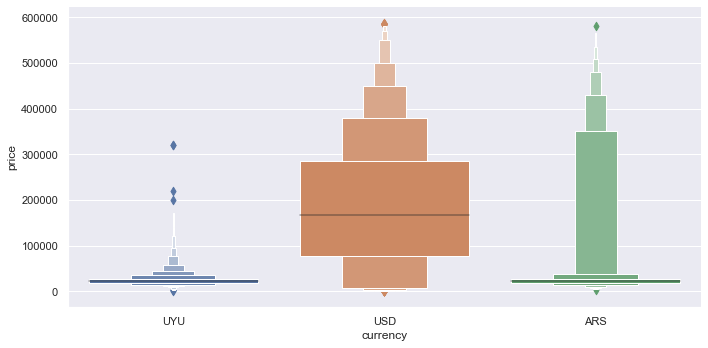

In [781]:
sns.catplot(data=data, x='currency', y='price', height=5, aspect=2, kind='boxen');

#### Property Type and Price

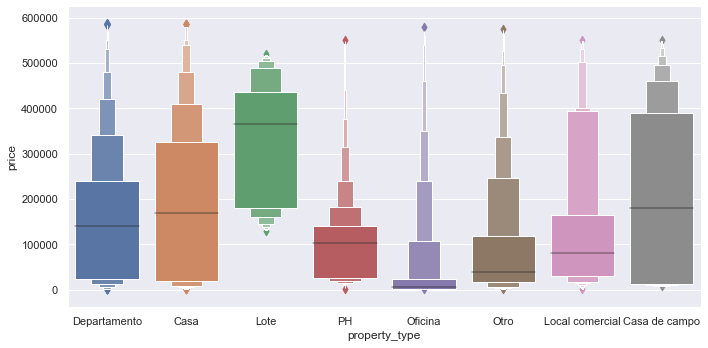

In [782]:
sns.catplot(data=data, x='property_type', y='price', height=5, aspect=2, kind='boxen');

#### Operation Type and Price

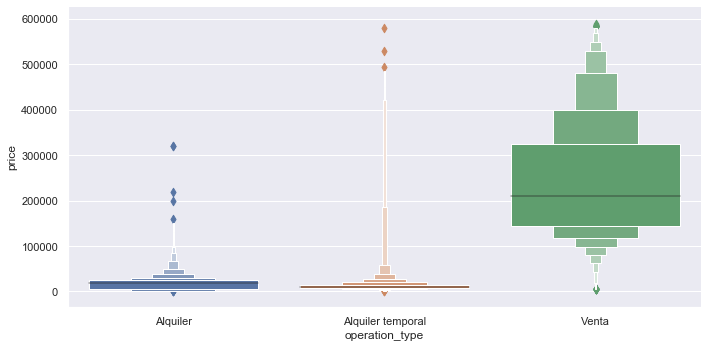

In [783]:
sns.catplot(data=data, x='operation_type', y='price', height=5, aspect=2, kind='boxen');

#### Months and Price

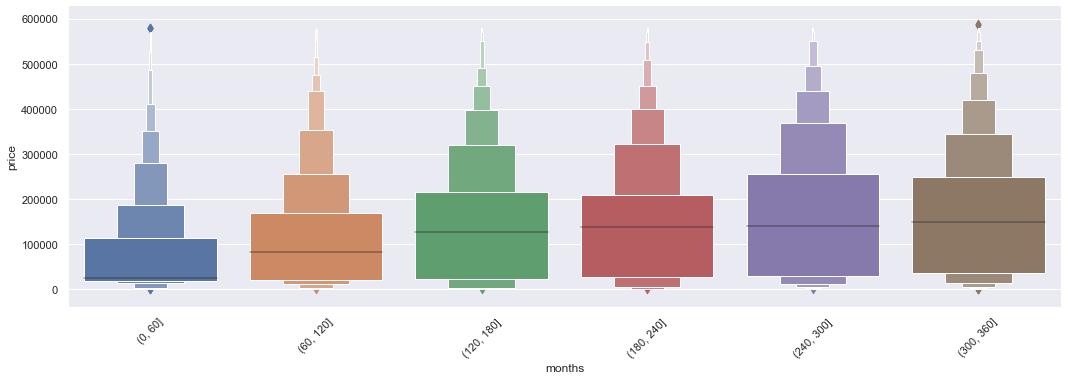

In [784]:
g = sns.catplot(data=data, x='months', y='price', height=5, aspect=3, kind='boxen');
g.set_xticklabels(rotation=45);

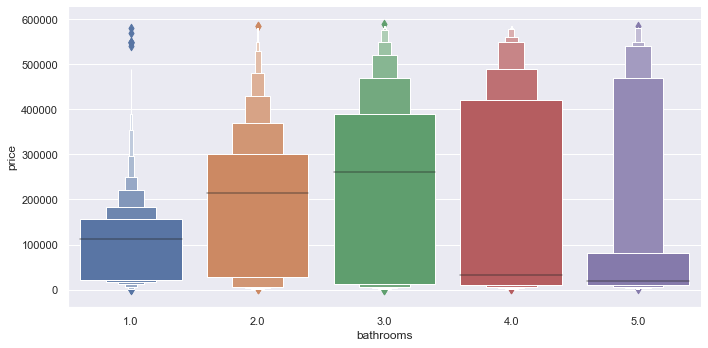

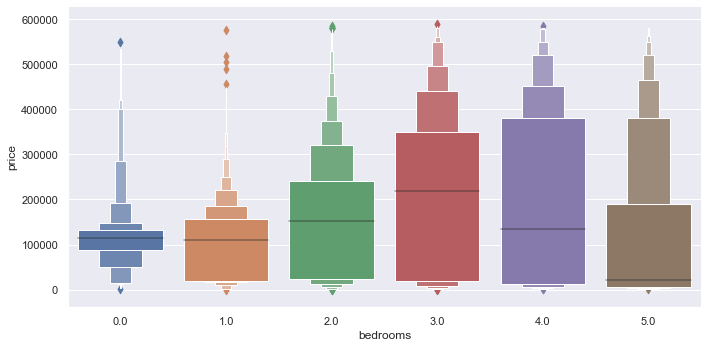

In [785]:
rest = ['bathrooms', 'bedrooms']
for i in rest:
    sns.catplot(data=data, x=i, y='price', height=5, aspect=2, kind='boxen');

# Model

In [786]:
data.head()

,lat,lon,l2,l3,bedrooms,bathrooms,price,currency,property_type,operation_type,months
1,-34.876799,-56.177896,Montevideo,Jacinto Vera,1.0,1.0,18000.0,UYU,Departamento,Alquiler,"(0, 60]"
3,-34.852340,-56.195110,Montevideo,Other,2.0,1.0,31000.0,UYU,Departamento,Alquiler,"(300, 360]"
4,-34.847868,-56.240044,Montevideo,Other,2.0,1.0,11500.0,UYU,Departamento,Alquiler temporal,"(300, 360]"
5,-34.903143,-56.159899,Montevideo,Parque Batlle,2.0,2.0,194000.0,USD,Departamento,Venta,"(300, 360]"
7,-34.917752,-56.164649,Montevideo,Punta Carretas,3.0,2.0,230000.0,USD,Departamento,Venta,"(300, 360]"


In [794]:
data_dummie = pd.get_dummies(data.drop(['lat', 'lon'], axis=1))
feats = data_dummie.drop('price', axis=1).columns

In [795]:
x = data_dummie.drop('price', axis=1).values
y = data_dummie['price'].values

rb = RobustScaler()
x = rb.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

## Lasso and Elastic

In [796]:
lasso = LassoCV(alphas=[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]).fit(x_train, y_train)
elastic = ElasticNetCV(alphas=[1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]).fit(x_train, y_train)

In [797]:
lasso_preds = (lasso.predict(x_test))
elas_preds = (elastic.predict(x_test))

real = (y_test)

print('Lasso: ',r2_score(real, lasso_preds))
print('Elastic: ',r2_score(real, elas_preds))

Lasso:  0.7494005060242352
Elastic:  0.7491176275873233


# XGBOOST

In [798]:
xgb = XGBRegressor(n_estimators=50, n_jobs=-1).fit(x_train, y_train)

xgb_preds = (xgb.predict(x_test))
print('Xgboost: ',r2_score(real, xgb_preds))

Xgboost:  0.8165637940223588


# Random Forest

In [800]:
forest = RandomForestRegressor(n_estimators=400, n_jobs=-1).fit(x_train, y_train)

forest_pred = (forest.predict(x_test))
print('Forest R2: ',r2_score(real, forest_pred))

Forest R2:  0.8066268909805012


In [801]:
importances = forest.feature_importances_
feats_imp = pd.DataFrame({'Feature':feats, 'Importance':importances})
feats_imp.sort_values(by='Importance', ascending=False)

,Feature,Importance
57,operation_type_Venta,0.618684
39,bathrooms_1.0,0.212147
40,bathrooms_2.0,0.043633
7,l3_Carrasco,0.008370
36,bedrooms_3.0,0.007245
62,"months_(240, 300]",0.005850
63,"months_(300, 360]",0.005416
49,property_type_Departamento,0.004797
24,l3_Pocitos,0.004696
28,l3_Punta Carretas,0.004644
